In [8]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/home/user/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
# Read csv - file
data = pd.read_csv('WAG_C_M.csv',sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

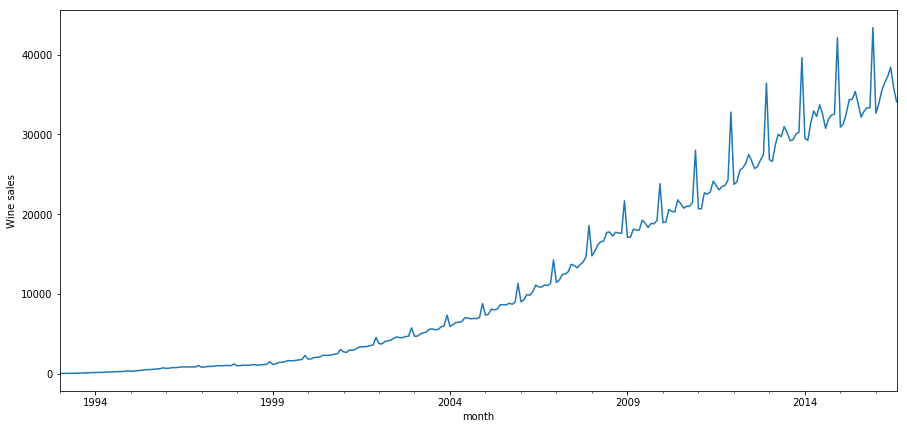

In [21]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Wine sales')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


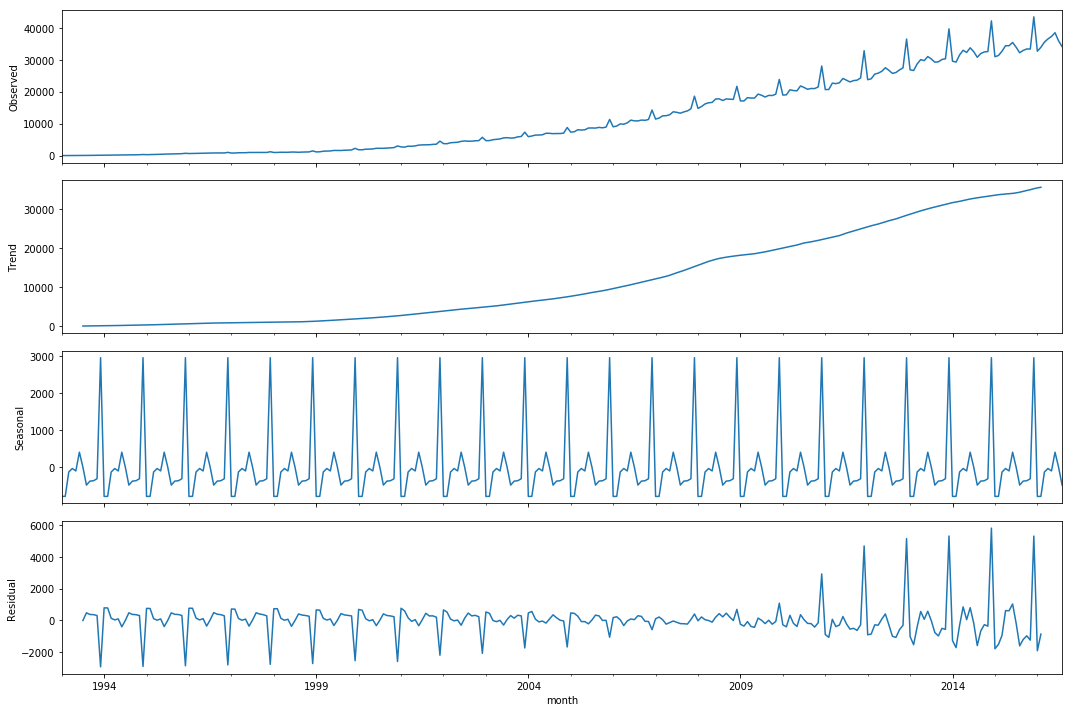

In [22]:
# Проверка стационарности и STL - декомпозиция
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


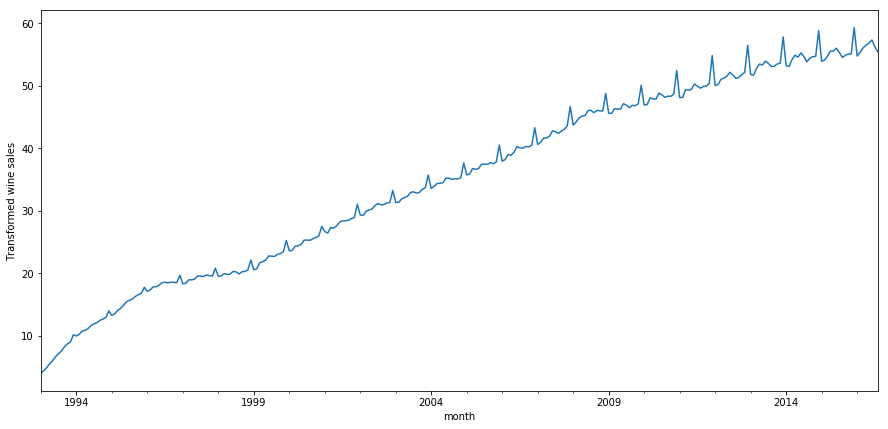

In [23]:
# Критерий Дики - Фуллера уверенно отвергает гипотезу о стационарности ряда
# Визуально также видно, что у ряда имеется ярко выраженный тренд и большая разница дисперсии в начале и конце ряда
#
# Применим преобразование Бокса - Кокса для стабилизации дисперсии
data['salary_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.salary_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box)[1])

Критерий Дики-Фуллера: p=0.014697


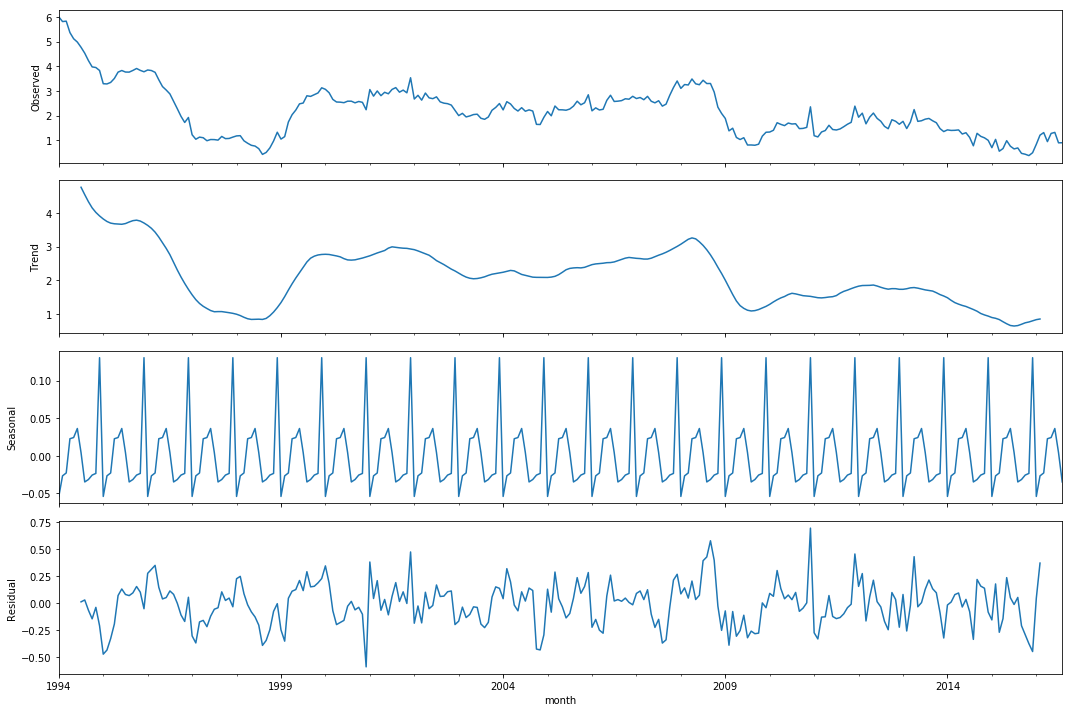

In [24]:
# После преобразования все еще критерий Дики - Фуллера отвергает гипотезу о стационарности, 
# но уже с меньшим значением
# Визуально по прежнему ряд имеет ярко выраженный тренд и различающуюся дисперсию
# Попробуем применить сезонное дифференцирование и применим к нему декомпозицию
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


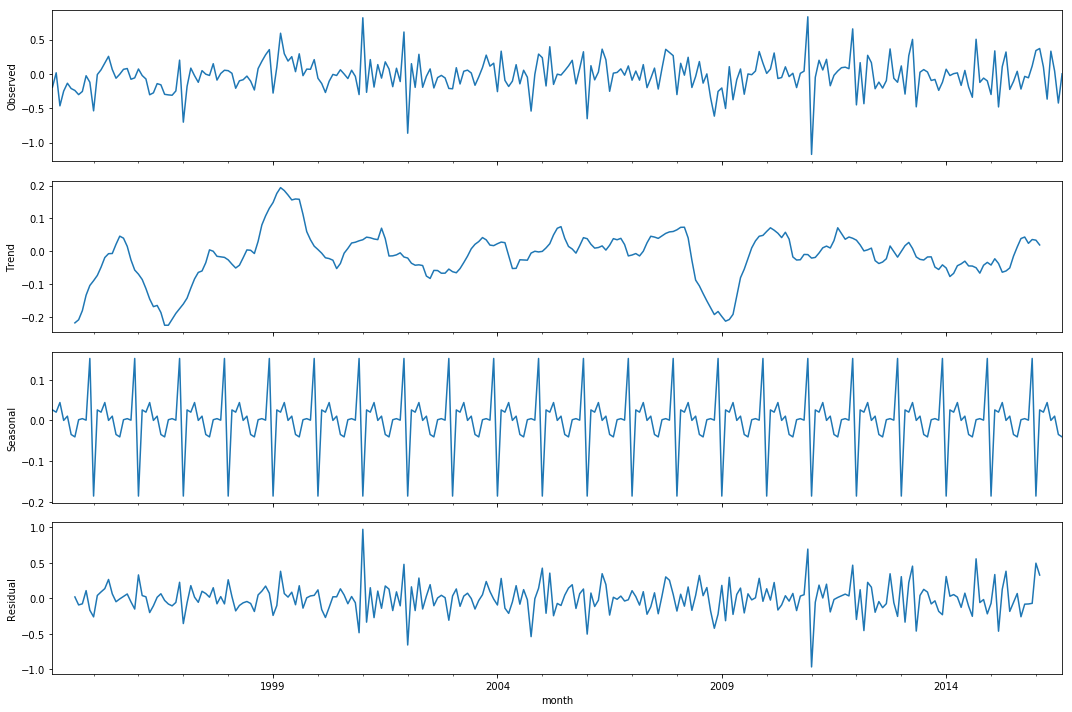

In [25]:
# Для ряда с сезонным дифференцированием, критерий Дики - Фуллера не отвергает гипотезу о нестационарности
# со значением p=0.014697. Но в ряду по прежнему имеется тренд.
# Попробуем добавить сезонное дифференцирование
data['salary_box_diff2'] = data.salary_box_diff - data.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.salary_box_diff2[13:])[1])

In [26]:
# Гипотеза нестационарности отвергается со значением p=0.000000 и тренда больше нет
# Гиперпараметры D - 1, d - 1

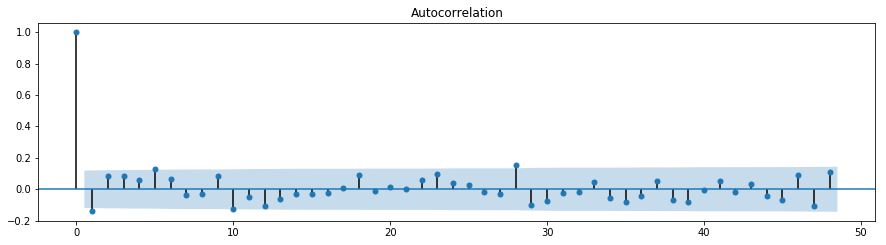

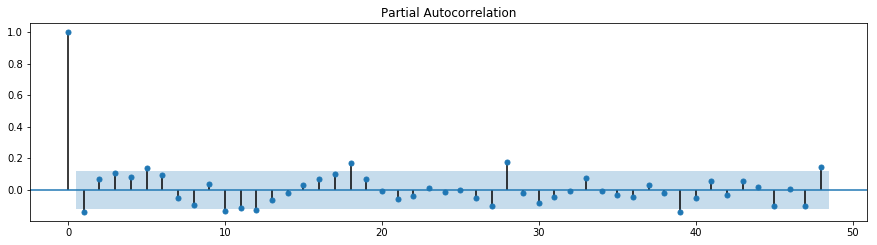

In [27]:
# Посмотрим на график автокорреляции и частичной автокорреляции ряда:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [44]:
# Начальные приближения: Q - 0 (так как нет значимых сезонных лагов), q - 5 28 (последний значимый несезонный лаг)
# Начальные приближения: P - 4 (последний значимый сезонный 48), p - 5 28 (последний значимый несезонный лаг)
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0,1)

In [45]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [48]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # print(len(results))
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


KeyboardInterrupt: 

In [49]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
26  (0, 5, 1, 0) -9.803174
27  (0, 5, 2, 0) -9.315767
41  (1, 2, 1, 0) -8.134235
29  (0, 5, 4, 0) -8.037312
28  (0, 5, 3, 0) -7.653950


In [50]:
# Лучшая модель:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(0, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  11.902
Date:                            Mon, 02 Mar 2020   AIC                             -9.803
Time:                                    21:47:09   BIC                             15.412
Sample:                                01-01-1993   HQIC                             0.321
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2414      0.047     -5.179      0.000      -0.333      -0.150
ma.L2          0.0642      0.073   

Критерий Стьюдента: p=0.153796
Критерий Дики-Фуллера: p=0.000000


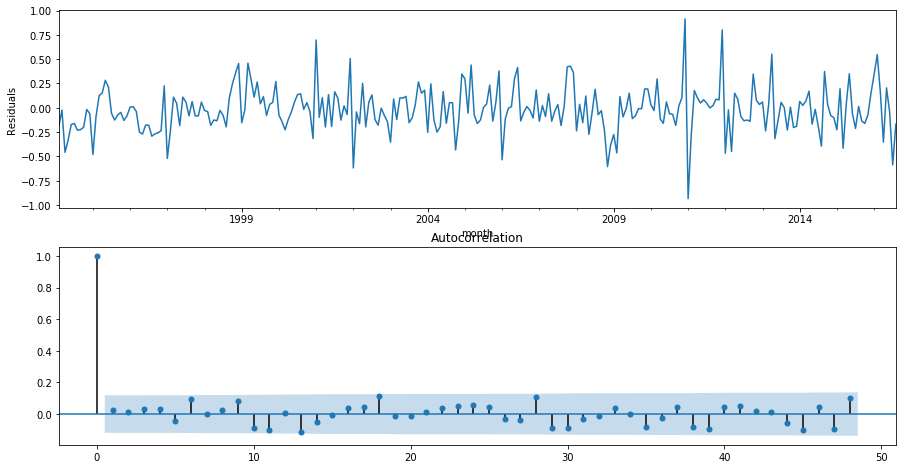

In [51]:
# Остатки лучшей модели
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [ ]:
# Остатки несмещены (подтверждается критерием Стьюдента) 
#         стационарны (подтверждается критерием Дики-Фуллера и визуально),
#         неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 
# Посмотрим, насколько хорошо модель описывает данные:

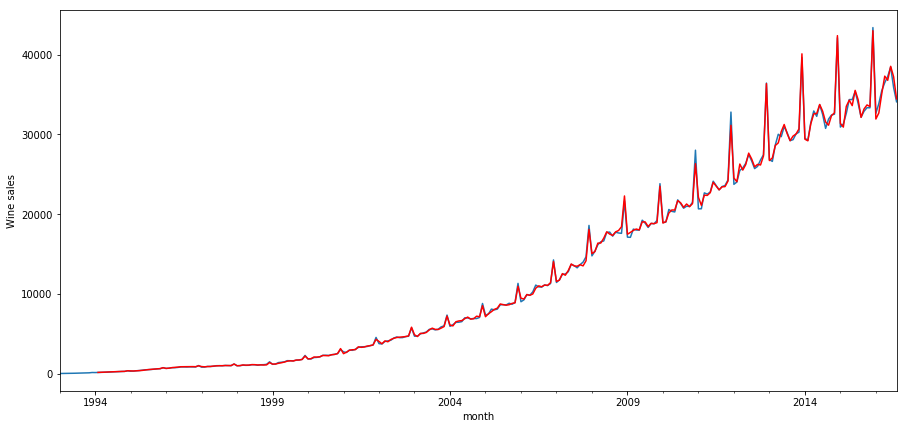

In [52]:
# Нарисуем
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

In [81]:
print('Длина ряда: ', str(len(data)))
print('Последняя дата в данных: ', data.index.max())

Длина ряда:  284
Последняя дата в данных:  2016-08-01 00:00:00


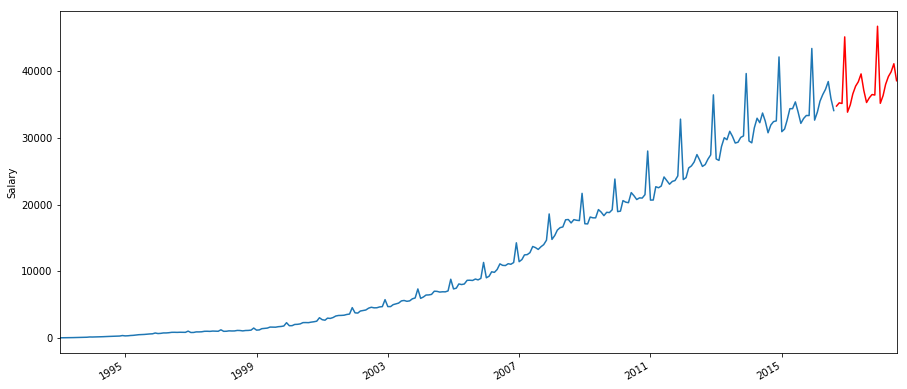

In [80]:
# Прогноз на 2 года (24 месяца с 2016-08-01):
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()